In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby


In [2]:

def waveform_sqdiff(t1, h1, t2, h2):
    t_ref = t1 
    
    search_deltat = np.linspace(-0.3,0.3,1500)
    mindiff = 1e10
    time_shift = 0
    for deltat in search_deltat:
        interpolator = scipy.interpolate.CubicSpline(t2+deltat, h2) 
        h2_interp = interpolator(t_ref)
        temp_diff = sum((h2_interp-h1)**2)
        if temp_diff<mindiff:
            mindiff = temp_diff
            time_shift = deltat
    
    return mindiff, time_shift

def get_dtdphi_withift(h1,h2,det=None):

    if det is None:
        det = bilby.gw.detector.InterferometerList(['L1'])[0]
        det.sampling_frequency = 8192
        det.duration = 8
    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = bilby.gw.utils.noise_weighted_inner_product(
                            aa=h1.conjugate()[freq_mask],
                            bb=(h2.conjugate() * np.exp(1j*phase1))[freq_mask],
                            power_spectral_density=det.power_spectral_density_array[freq_mask],
                            duration=8)
    
    deltaphi = -np.angle(inner_product)
    
    return deltat,deltaphi


def get_shifted_h2(h1,h2,det=None):
    '''
    Return the h2*exp(-i*phase_shift), i.e. h2* exp -i*(2\pi f \Delta t + \Delta \phi)
    '''
    if det is None:
        det = bilby.gw.detector.InterferometerList(['L1'])[0]
        det.sampling_frequency = 8192
        det.duration = 8
    deltat,deltaphi = get_dtdphi_withift(h1,h2,det)
    f_array = det.frequency_array
    exp_phase = np.exp(-1j*(2*np.pi*f_array*deltat + deltaphi) )
    return h2*exp_phase

def shift_h2_td(h1, h2):
    h1_fd = np.fft.rfft(h1)
    h2_fd = np.fft.rfft(h2)

    h2_fd_shifted = get_shifted_h2(h1_fd,h2_fd)
    h2_td_shifted = np.fft.irfft(h2_fd_shifted)

    return h2_td_shifted

def maxima_shift(t1, h1, t2, h2):
    index_t1max = np.argmax(h1)
    index_t2max = np.argmax(h2)
    
    return t1[index_t1max] - t2[index_t2max]
    

In [3]:
torch.cuda.is_available()

True

In [4]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_stchresp_nasp5_qp5_2N2000_Pv2v4P.h5'

Ngw = gwutils.get_gwh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

cut_fraction = [0.6,0.05]
gw_dataset = gwutils.GWDatasetCutStReMultimodel(h5filename, cut_fraction, root_dir, train_index)
gw_test_dataset = gwutils.GWDatasetCutStReMultimodel(h5filename, cut_fraction, root_dir, test_index)
gw_valid_dataset = gwutils.GWDatasetCutStReMultimodel(h5filename, cut_fraction, root_dir, valid_index)


In [5]:
train_label = 'IMRPv2EOBv4P_q5_nas5_2N2000_bicut60to95_StRe'

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [21]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.5, b=0.6), targets_getter=get_all_indcs, #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [22]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [23]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=False,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=1e-4,
    decay_lr=10,
    seed=123,
    batch_size=16,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=50,
    **KWARGS
)




--- Training IMRPv2EOBv4P_q5_nas5_2N2000_bicut60to95_StRe/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1     7873.5839     5011.5054     +  4.3411


      2     4632.2834     3578.6167     +  2.9242


      3     1060.8053    -1002.5079     +  2.8754


      4    -1355.6969      -58.4636        2.9302


      5    -2134.5411    -2641.7660     +  2.8623


      6    -2717.1956     -185.0190        2.8049


      7    -2497.1916    -2746.9515     +  2.7792


      8    -3389.3430    -3624.1594     +  2.7234


      9     -526.2613     -751.8365        2.6316


     10    -1763.5893    -2780.7074        2.6708


     11    -3213.6734    -3769.8913     +  2.7847


     12    -3635.2089    -3681.7275        2.7496


     13    -3700.0586    -3863.2345     +  2.7374


     14    -3941.4016    -4113.3216     +  2.8226


     15    -3823.5622    -4076.4918        2.6933


     16    -3926.6366    -4246.3321     +  2.8611


     17    -4031.1156    -4126.2813        2.8548


     18    -4131.2698    -4416.7551     +  2.8658


     19    -4243.1148    -4598.2102     +  2.9336


     20    -4208.3366    -4487.7238        2.8233


     21    -4398.2572    -4643.7265     +  2.8146


     22    -4400.2361    -4556.0988        2.8481


     23    -4285.2887    -4599.8669        2.8206


     24    -4247.2675    -4344.3226        2.8975


     25    -4428.4166    -4433.5874        2.8430


     26    -4584.3458    -4641.9182        2.8476


     27    -4571.7678    -4708.8977     +  2.8957


     28    -4529.2769    -4539.0771        2.8199


     29    -4622.6858    -4680.4977        2.9791


     30    -4598.7089    -4482.1148        2.9226


     31    -4677.3133    -4633.7821        3.2351


     32    -4701.9347    -4693.6709        3.1001


     33    -4550.2773    -4773.5853     +  3.1378


     34    -4669.6098    -4934.5859     +  2.9234


     35    -4749.5430    -4867.4592        2.7890


     36    -4721.6827    -4873.9063        2.4460


     37    -4780.7328    -4805.3009        2.4165


     38    -4848.4005    -4762.2831        2.3884


     39    -4825.2779    -4872.2905        2.4094


     40    -4866.7151    -4879.9441        2.4555


     41    -4892.5087    -4920.2912        2.4174


     42    -4828.8114    -5028.6298     +  2.4060


     43    -4864.4603    -4983.7600        2.3937


     44    -4828.9350    -4808.8872        2.4078


     45    -4914.9782    -4998.4868        2.4420


     46    -4858.2050    -5097.1234     +  2.4263


     47    -4912.3414    -4970.1937        2.4687


     48    -4959.1762    -5025.6730        2.5042


     49    -4961.6311    -5168.3980     +  2.4674


     50    -4965.1957    -4981.7154        2.5276


IMRPv2EOBv4P_q5_nas5_2N2000_bicut60to95_StRe/ConvCNP/run_0 | best epoch: 49 | train loss: -4965.1957 | valid loss: -5168.398 | test log likelihood: 5014.585


In [24]:
model_pv2v4p_7d = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [33]:
model_index_imr = 0
model_index_eob = 1

test_phyindex = 4
#x_test_imr, y_test_imr = testset.get_specific_model_unresampled(model_index_imr, test_phyindex)
#x_test_eob, y_test_eob = testset.get_specific_model_unresampled(model_index_eob, test_phyindex)

x_test_imr, y_test_imr = gw_test_datasets[f'{train_label}'][2*test_phyindex]
x_test_eob, y_test_eob = gw_test_datasets[f'{train_label}'][2*test_phyindex+1]

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]

In [34]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p_7d, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p_7d, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)

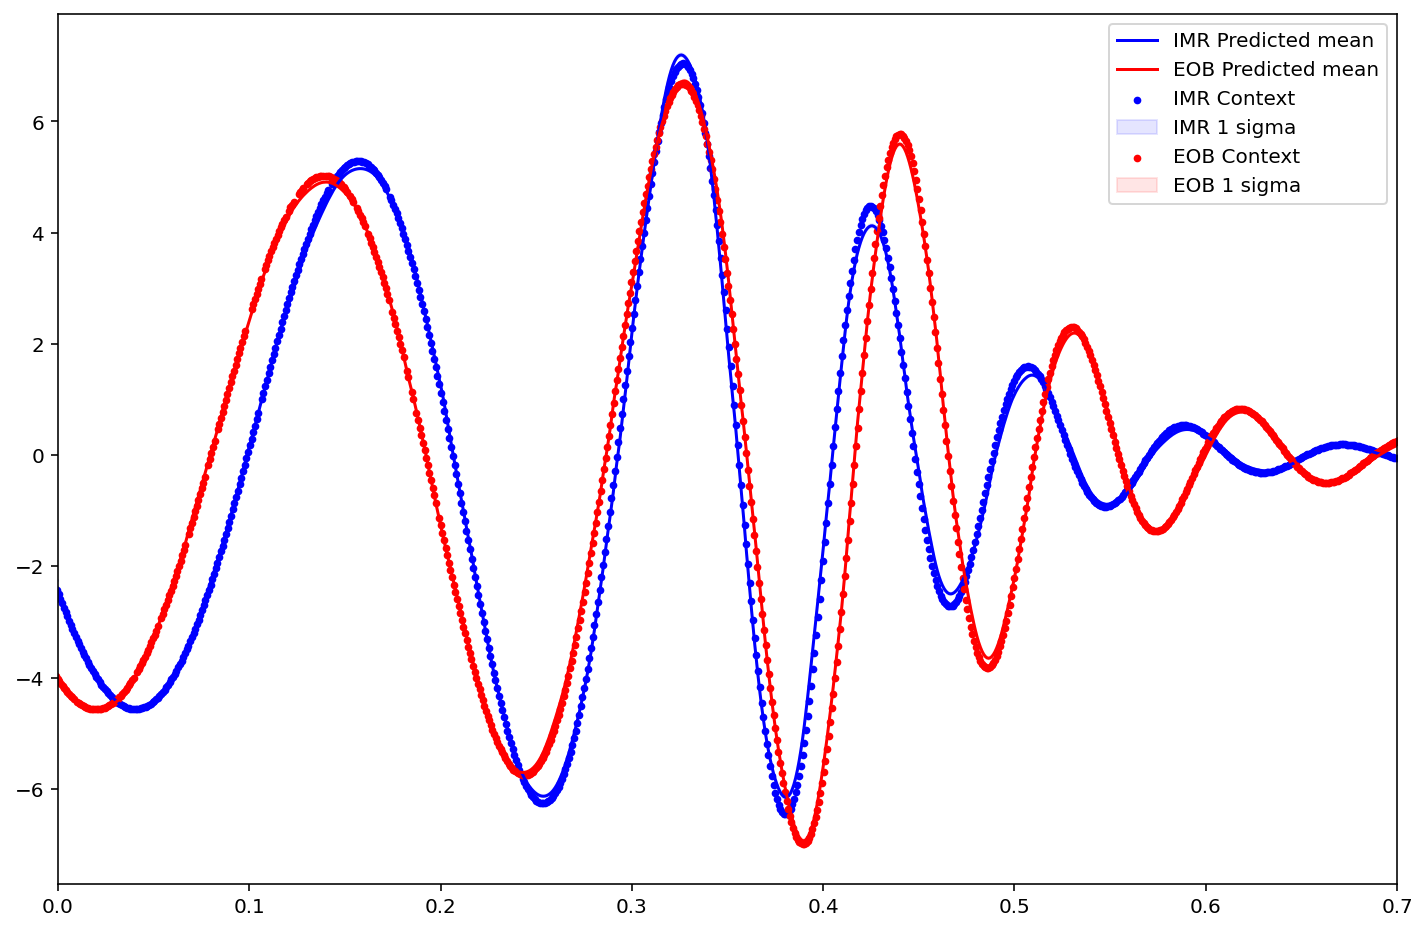

In [36]:
plt.figure(figsize=(12,8))

#plt.plot(x_test_imr, y_test_imr, label='IMR Target function', color='k')
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=8)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')

#diff, tshift = waveform_sqdiff(x_test_imr.squeeze().numpy(), y_test_imr.squeeze().numpy(),
#             x_test_eob.squeeze().numpy(), y_test_eob.squeeze().numpy())
tshift=maxima_shift(x_test_imr.squeeze().numpy(), y_test_imr.squeeze().numpy(),
             x_test_eob.squeeze().numpy(), y_test_eob.squeeze().numpy())

#tshift=0
#y_eob_shifted = shift_h2_td(y_test_imr.squeeze().numpy(), y_test_eob.squeeze().numpy())
#plt.plot(x_test_eob, y_test_eob, label='EOB Target function', color='k')
plt.scatter(x_test_context_eob+tshift, y_test_context_eob, label='EOB Context', color='r',s=8)
plt.plot(x_test_target_eob+tshift, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze()+tshift, y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')


plt.legend()
plt.xlim(-0.,0.7)
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

In [29]:
def test_plots(dataset, model, testnum=10, subplotshape=(5,2), figsize=(20,20) ):
    plt.figure(figsize=figsize)
    for testindex in range(testnum):
        x_test, y_test = dataset[testindex]

        len_data = len(x_test)
        len_context = int(len_data*1)
        context_index = np.sort( np.random.permutation(len_data)[:len_context] )
        target_index = np.arange(len_data)

        x_test_context = x_test[context_index]
        y_test_context = y_test[context_index]

        x_test_target = x_test[target_index]
        x_yest_target = y_test[target_index]

        nsample = 1
        mean, std = gwutils.get_predictions(model, x_test_context.unsqueeze(0), y_test_context.unsqueeze(0),
                                    x_test_target.unsqueeze(0), nsample)

        plt.subplot(subplotshape[0],subplotshape[1], testindex+1)
        plt.plot(x_test, y_test, label='Target function', color='k')
        plt.scatter(x_test_context, y_test_context, label='Context', color='b',s=8)
        plt.plot(x_test_target, mean, label='Predicted mean', color='r',linestyle='--')
        plt.fill_between(x=x_test_target.squeeze(), y1=mean-std, y2=mean+std, label='1 sigma', alpha=0.1, color='r')
        plt.text(x=-0.5,y=-6, s=f"test id: {testindex}")
        if testindex in [0,1]:
            plt.legend()
    
    plt.show()

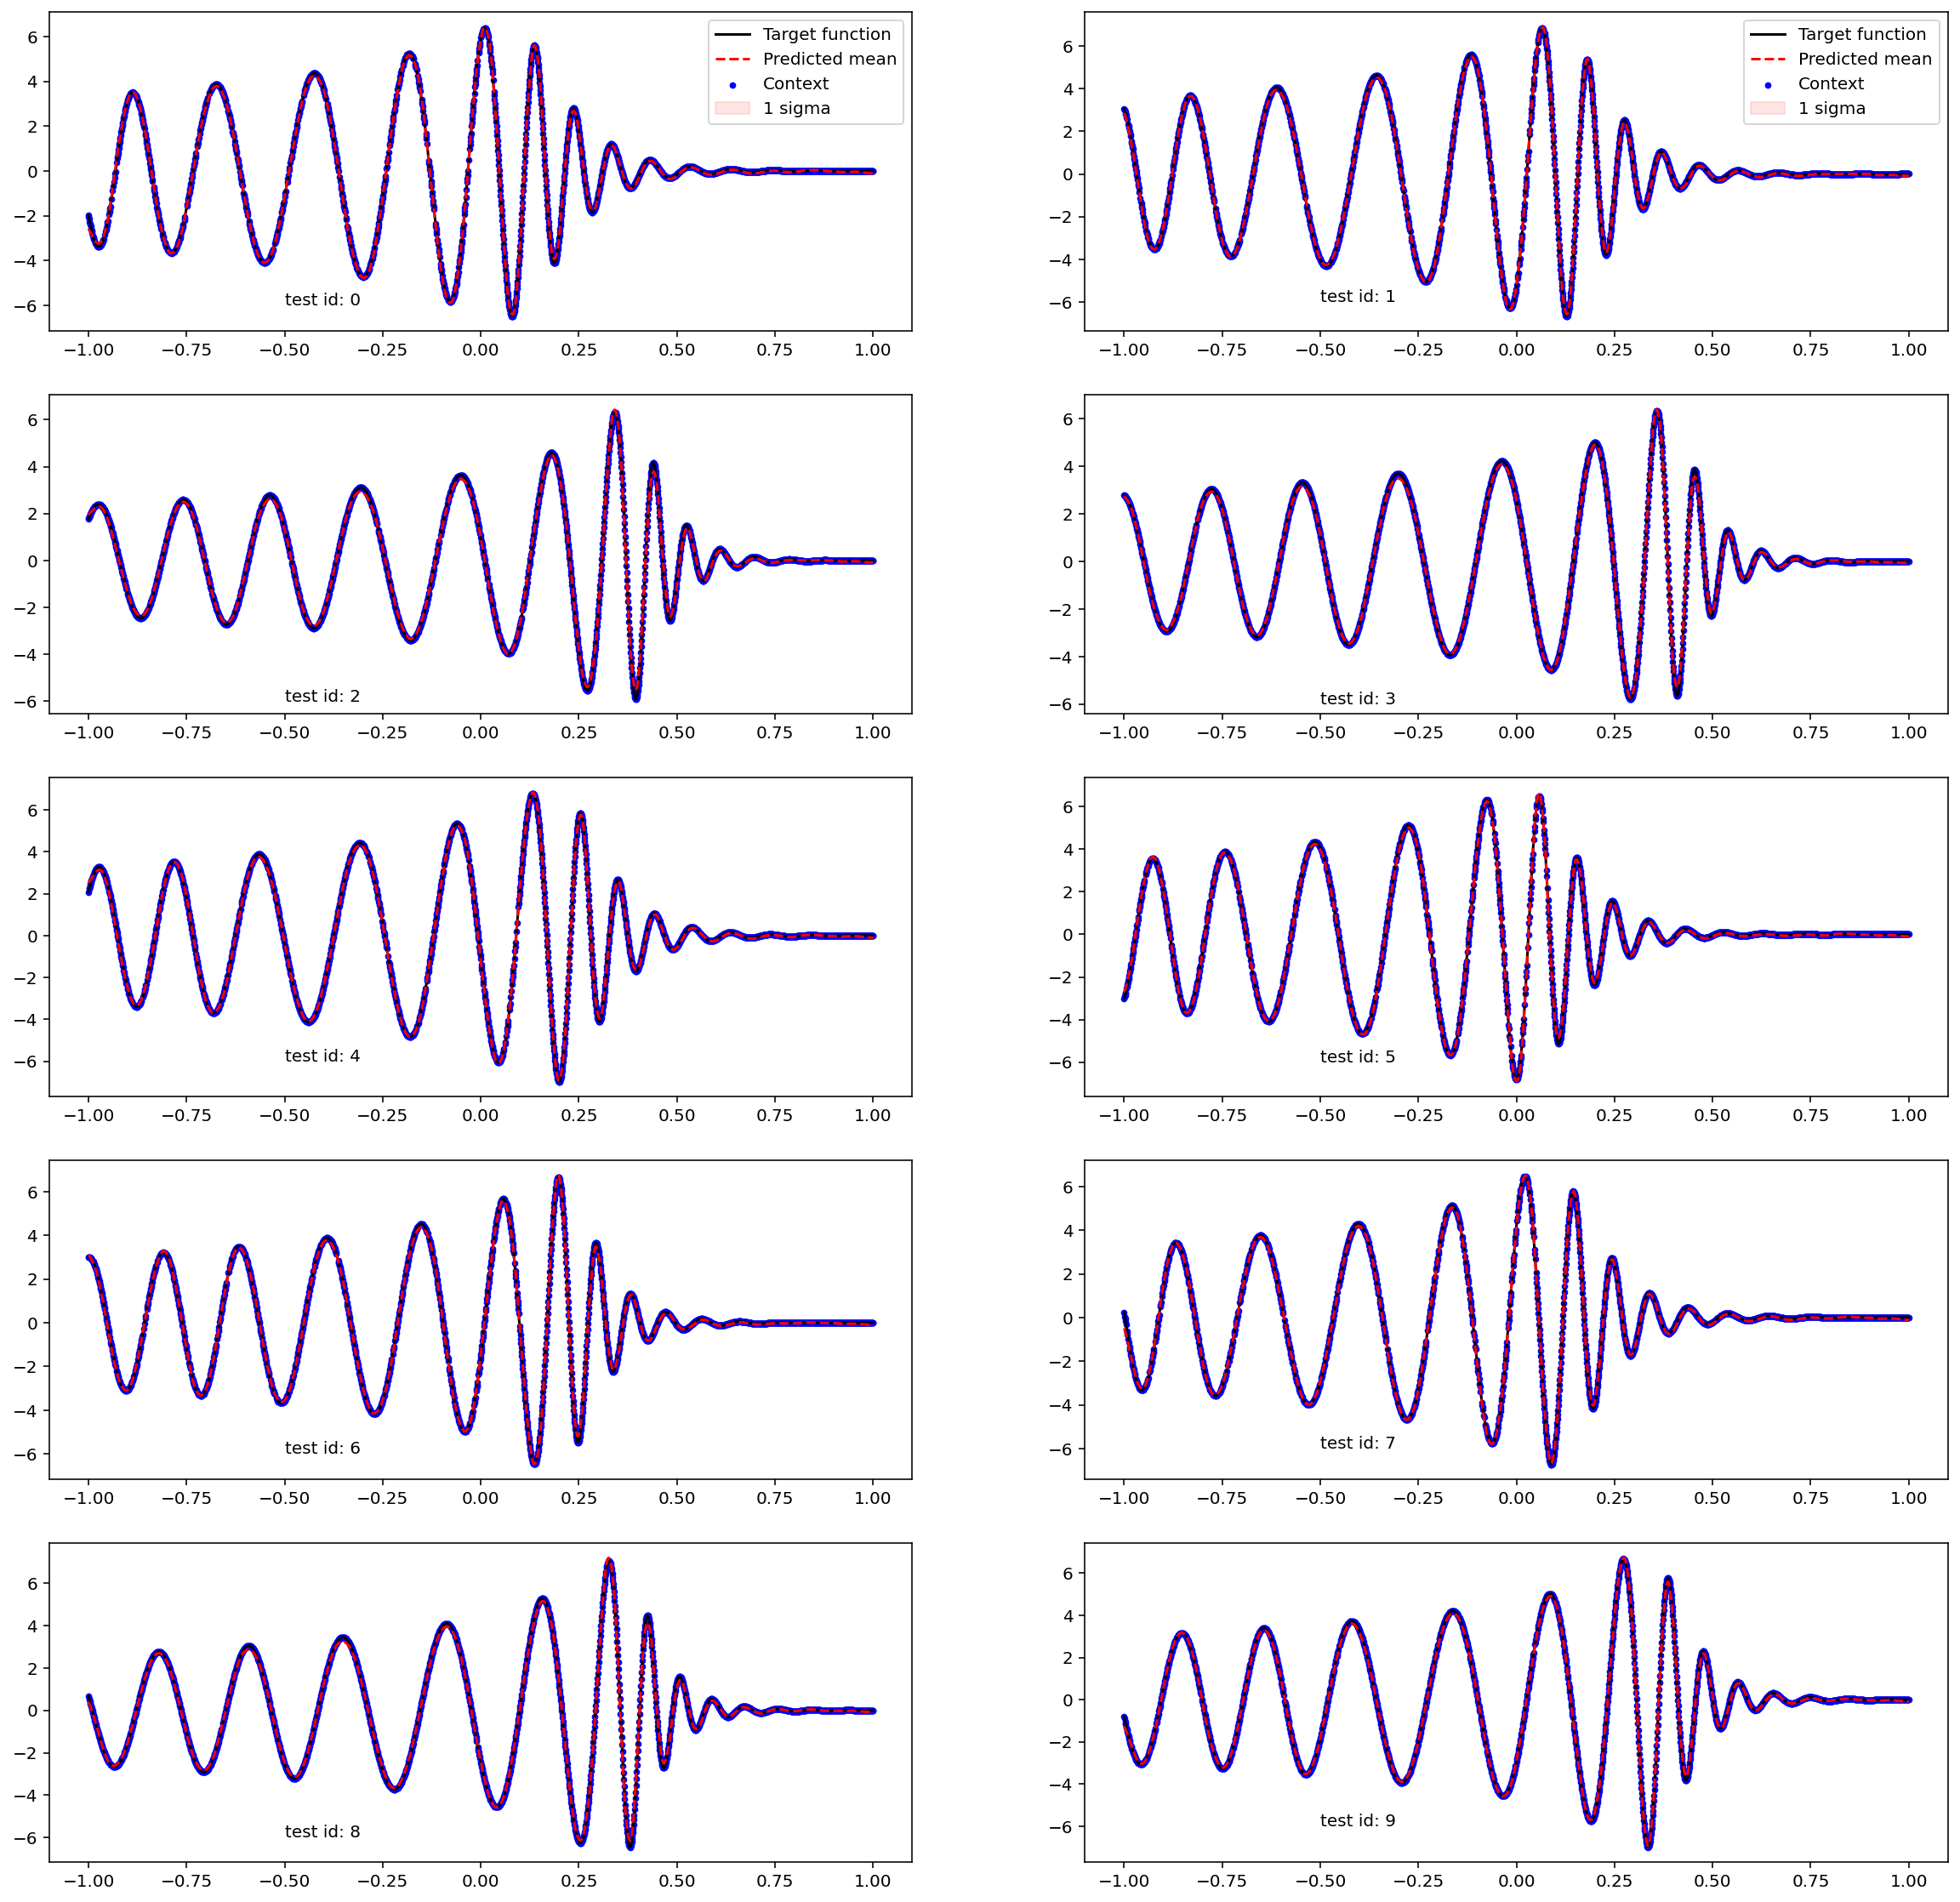

In [30]:
test_plots(dataset=gw_test_datasets[f'{train_label}'], model=model_pv2v4p_7d)